# Ganesharow Bappoo - C0909659

# 1.0 Import Libraries
We begin by importing the libraries necessary for the entire process. pandas and numpy are for data handling. matplotlib and seaborn are for data visualization to help us see the distributions and patterns. nltk is for natural language processing, specifically for handling text data. The sklearn libraries are for building and evaluating our machine learning model. joblib is for saving our model for later use.


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from wordcloud import WordCloud
import joblib

# 2.0 Load Dataset
We will now load the dataset into a pandas DataFrame. Pandas is a powerful tool that allows for sophisticated data manipulation and analysis. By reading the CSV into a DataFrame, we can easily access and manipulate the data. After loading the dataset, we will take a peek at the first few rows using df.head() to understand what our data looks like.



In [2]:
#The file is named 'completeSpamAssassin.csv' and is in the same directory as the notebook
df = pd.read_csv('SpamAssassin.csv')

In [3]:
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [5]:
df.describe()

,Unnamed: 0,Label
count,6046.000000,6046.000000
mean,3022.500000,0.313596
std,1745.474195,0.463993
min,0.000000,0.000000
25%,1511.250000,0.000000
50%,3022.500000,0.000000
75%,4533.750000,1.000000
max,6045.000000,1.000000


Upon loading the dataset, we see that it comprises various columns that potentially include the content of emails along with their corresponding labels indicating whether an email is spam or not. To fully grasp the scope of the dataset, we would assess the number of rows, which represent individual email entries, and the number of columns, which denote the attributes or features of each email, such as the subject, body, and sender information.

To thoroughly understand the nature of the data, it's crucial to identify if there are any missing values that could affect our analysis or require preprocessing. Additionally, the balance between spam and non-spam (ham) emails will be pivotal to observe since it can significantly influence the performance of our machine learning model. The datatype of each column will also be noted, as text data will need to be processed differently from numerical data when we move towards feature engineering and model training.

# 3.0 Data Cleaning

In [6]:
# Dropping the 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Dropping rows with any missing values
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6045 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    6045 non-null   object
 1   Label   6045 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 141.7+ KB


We now see that the column has been dropped, and there is no missing values

In [8]:
df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


# 4.0 EDA

### Distribution of Spam vs. Non-Spam emails

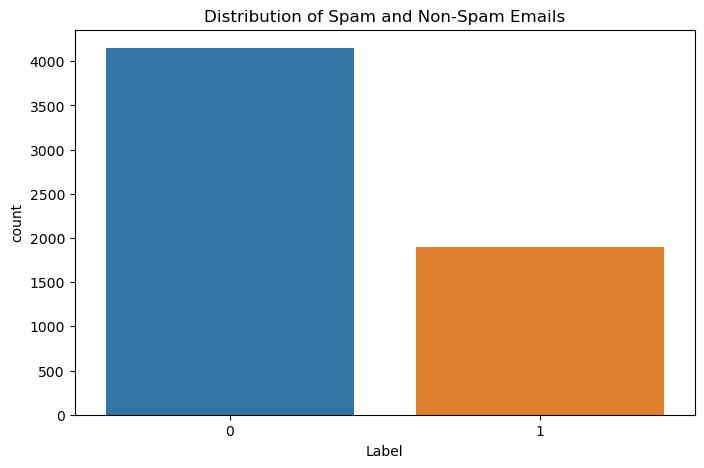

In [9]:
# Plotting the distribution of Spam vs. Non-Spam emails
plt.figure(figsize=(8, 5))
sns.countplot(x='Label', data=df)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.show()

This visual insight into the distribution will inform us if we need to balance the dataset before training our model to prevent bias towards the more common class.

The bar chart illustrates the distribution of spam and non-spam emails in the dataset. From the bar chart, we can observe a significant imbalance: non-spam emails (labeled as `0`) outnumber the spam emails (labeled as `1`). This imbalance is common in spam detection datasets and reflects real-world conditions where genuine emails usually exceed spam.

In predictive modeling, such class imbalance could bias the model towards predicting the majority class. To address this, techniques like resampling the minority class, using class weights, or evaluating the model with metrics that give a better sense of performance on imbalanced data (such as F1-score, precision, recall, and ROC AUC) may be required. It's important to consider these factors during the modeling stage to ensure the classifier does not simply learn to predict the majority class.

### Email Length Distribution

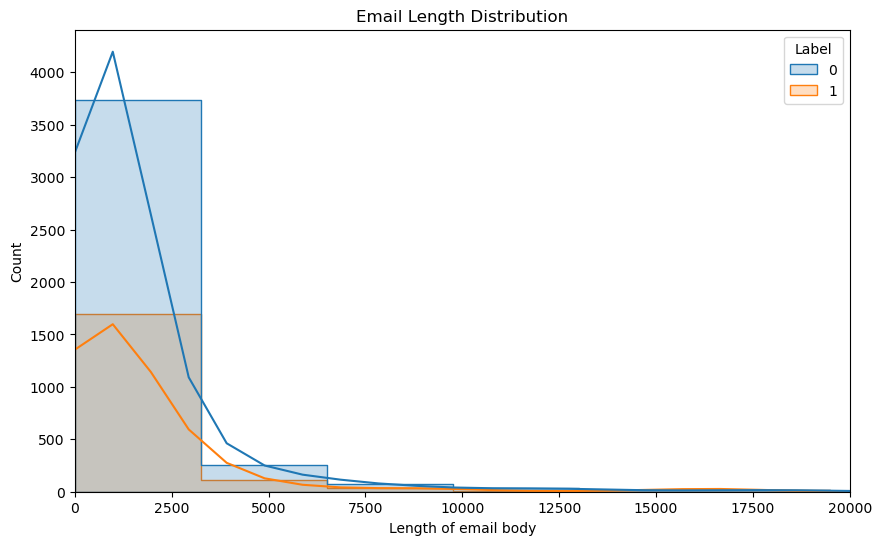

In [10]:
# Calculating the length of each email
df['length'] = df['Body'].apply(len)

# Plotting the distribution of email lengths by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='Label', bins=60, kde=True, element='step')
plt.title('Email Length Distribution')
plt.xlim(0, 20000)  # Adjust this limit based on the distribution you observe
plt.xlabel('Length of email body')
plt.ylabel('Count')
plt.show()

The histogram indicates that most emails, whether spam or not, are short, with a significant concentration under 2,500 characters. Non-spam emails commonly peak below 500 characters, whereas spam emails have a broader length distribution, suggesting variability in spam content. Notably, spam emails tend to include longer messages as well, which could be useful in distinguishing between the two classes when we design our spam detection model.

### Spam Email WordCloud

In [11]:
import nltk

# Download the stopwords from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ganesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

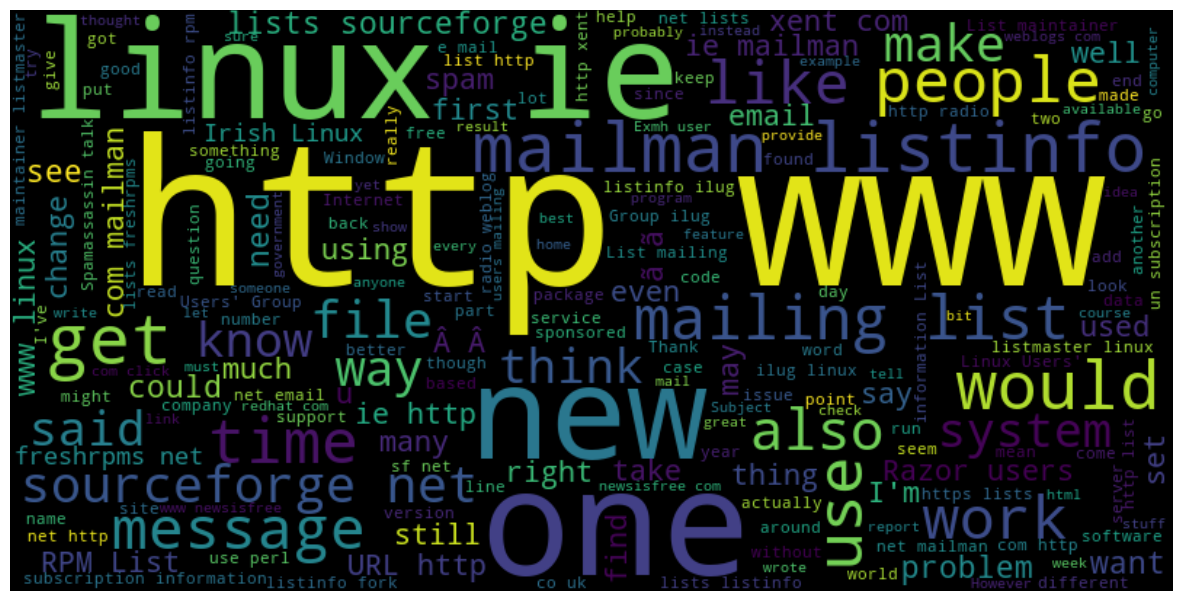

In [18]:
# Combining all non-spam emails into a single text
non_spam_emails = ' '.join(df[df['Label'] == 0]['Body'])

# Generating a word cloud for non-spam emails
wordcloud_non_spam = WordCloud(width=800, height=400, background_color ='black', 
                           stopwords = set(stopwords.words('english')), min_font_size = 10).generate(non_spam_emails)

# Displaying the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_non_spam, interpolation='bilinear')
plt.axis('off')
plt.show()

### Spam Email WordCloud

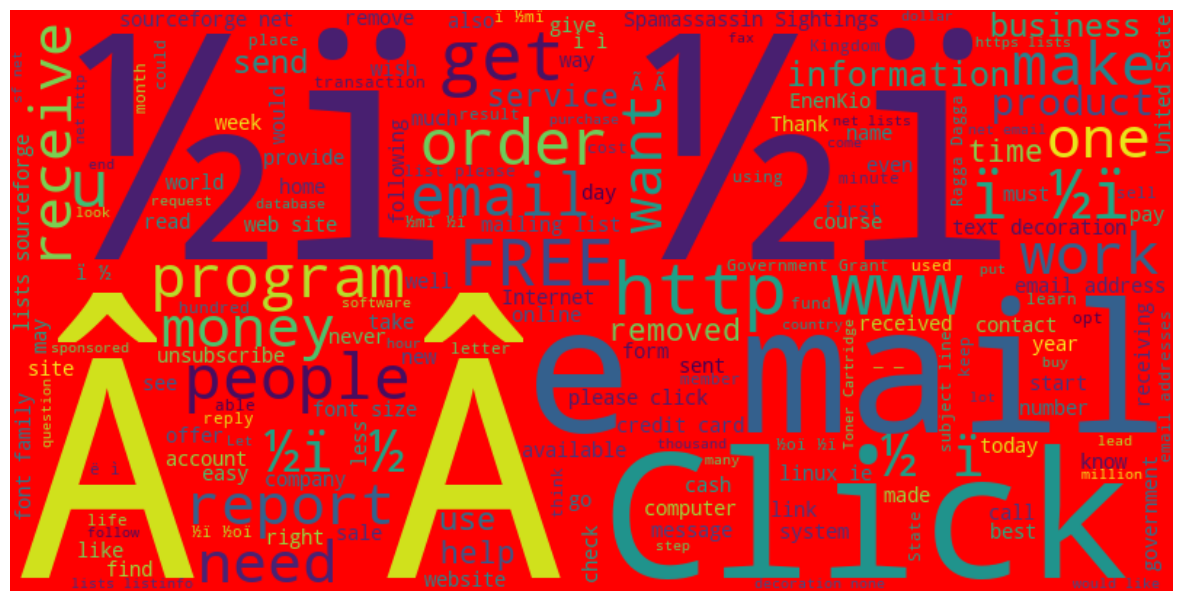

In [17]:
# Combining all spam emails into a single text
spam_emails = ' '.join(df[df['Label'] == 1]['Body'])

# Generating a word cloud for non-spam emails
wordcloud_spam = WordCloud(width=800, height=400, background_color ='red', 
                           stopwords = set(stopwords.words('english')), min_font_size = 10).generate(spam_emails)

# Displaying the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.show()

### Analysis of Word Count and Frequency Distribution

[nltk_data] Downloading package punkt to /Users/ganesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ganesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


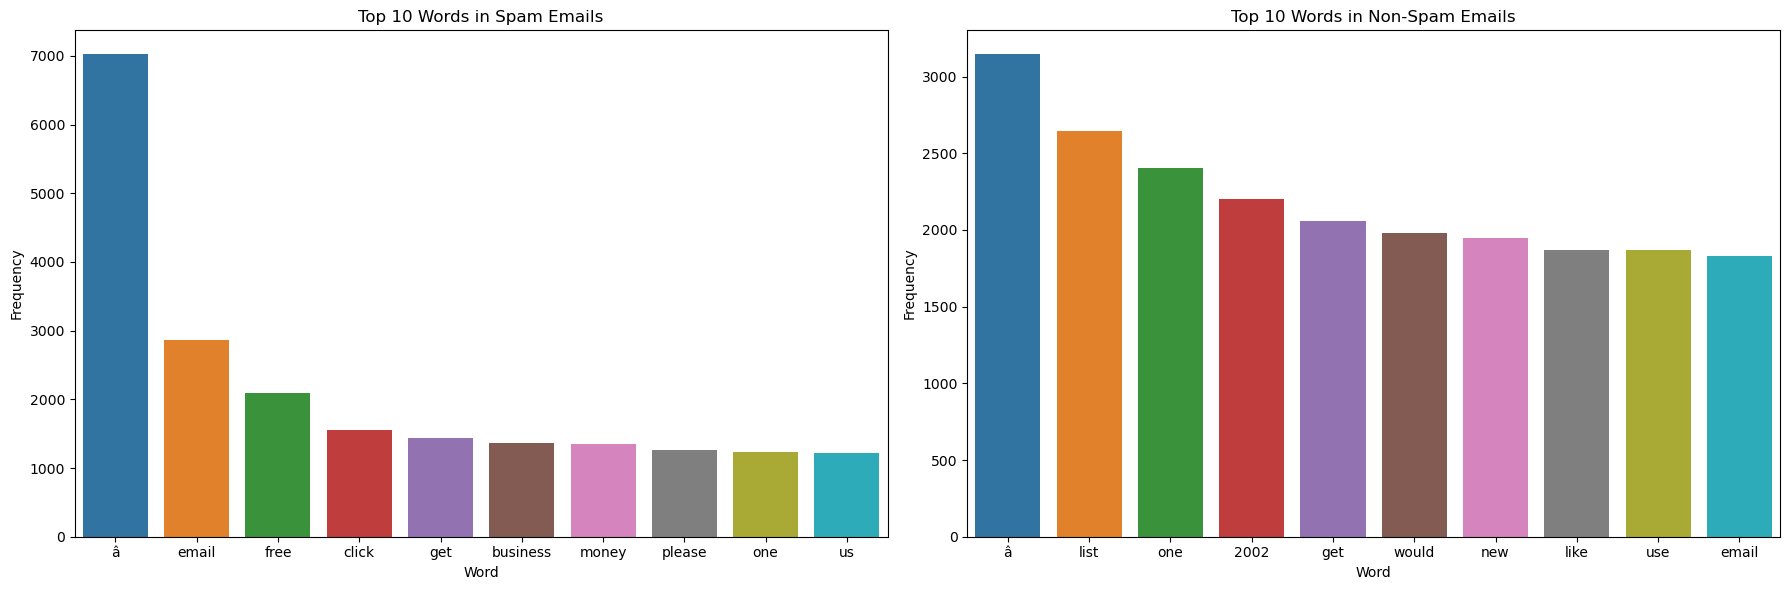

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

#Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


#Preprocessing function to remove punctuation and stop words
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    stop_words_set = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words_set]
    return ' '.join(tokens)

#Apply preprocessing to the email bodies
df['Processed_Body'] = df['Body'].apply(preprocess_text)

#Define a function to get the top n words in a corpus
def get_top_n_words(corpus, n=None):
    # Tokenize the text
    tokens = word_tokenize(corpus)
    # Create a frequency distribution
    word_freq = nltk.FreqDist(tokens)
    # Get the most common words
    return word_freq.most_common(n)

# Combine all processed spam and non-spam emails into separate strings
spam_corpus = ' '.join(df[df['Label'] == 1]['Processed_Body'])
non_spam_corpus = ' '.join(df[df['Label'] == 0]['Processed_Body'])

# Get the top 10 words for spam and non-spam emails
top_spam_words = get_top_n_words(spam_corpus, 10)
top_non_spam_words = get_top_n_words(non_spam_corpus, 10)

# Create DataFrames for easy plotting
top_spam_df = pd.DataFrame(top_spam_words, columns=['Word', 'Frequency'])
top_non_spam_df = pd.DataFrame(top_non_spam_words, columns=['Word', 'Frequency'])

# Plot the top words in spam and non-spam emails
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Spam words bar plot
sns.barplot(ax=axes[0], x='Word', y='Frequency', data=top_spam_df)
axes[0].set_title('Top 10 Words in Spam Emails')

# Non-spam words bar plot
sns.barplot(ax=axes[1], x='Word', y='Frequency', data=top_non_spam_df)
axes[1].set_title('Top 10 Words in Non-Spam Emails')

plt.tight_layout()
plt.show()


In [15]:
top_spam_df

,Word,Frequency
0,â,7021
1,email,2864
2,free,2093
3,click,1552
4,get,1430
5,business,1363
6,money,1353
7,please,1259
8,one,1233
9,us,1219


In [16]:
top_non_spam_df

,Word,Frequency
0,â,3144
1,list,2646
2,one,2402
3,2002,2200
4,get,2057
5,would,1978
6,new,1946
7,like,1872
8,use,1867
9,email,1833


The top words in both spam and non-spam emails after stop words have been removed. Interestingly, we see the word 'email' features prominently in both, which is expected given the dataset's nature. The presence of words like 'free', 'click', 'business', and 'money' among the top spam words fits the common patterns associated with spam content, which often include such enticements or commercial terms.

# 5.0 Feature Engineering

Feature engineering for text data typically involves creating a numerical representation of the text that can be used by machine learning algorithms. For this dataset, we can create features based on the text content and some meta-features like the length of the emails. After that, we can use dimensionality reduction techniques like t-SNE or PCA to visualize the features.

### Text Vectorization
This process entails converting the cleaned text data into numerical features using TF-IDF. This technique transforms the text into a sparse matrix of term frequencies weighted by their importance across all documents.

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize



# Load the dataset
# Make sure to change this filepath to the correct location of your dataset
df = pd.read_csv('SpamAssassin.csv')

# Drop rows with NaN values in the 'Body' column
df = df.dropna(subset=['Body'])

# Preprocessing function to remove punctuation and stopwords
def preprocess_text(text):
    # Convert to string in case there are any non-string entries
    text = str(text)
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words_set = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words_set and word.isalpha()]
    
    return ' '.join(tokens)

# Apply preprocessing to the email bodies
# Replace 'Body' with the actual name of your text content column
df['Clean_Body'] = df['Body'].apply(preprocess_text)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

# Fit and transform the 'Clean_Body' column to create TF-IDF features
# The vectorizer returns a sparse matrix by default, so we convert it to an array
features = tfidf_vectorizer.fit_transform(df['Clean_Body']).toarray()

# If you want to create a DataFrame of the features with their corresponding terms
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(features, columns=feature_names)

In [31]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6045 entries, 0 to 6044
Columns: 28938 entries, aa to çš çš
dtypes: float64(28938)
memory usage: 1.3 GB


Output indicates that after vectorizing  text data using TF-IDF, we have a DataFrame with 6,045 emails (entries) and a very large number of features (28,938), each representing a unique term in the TF-IDF matrix. -  -Every column corresponds to a term (word or bigram), and the value is the TF-IDF score of that term in each email.

However, the output also suggests that the DataFrame is quite large, consuming about 1.3 GB of memory. 
This size is likely due to the high dimensionality of the data, with many unique words and bigrams creating a sparse matrix with a lot of zeros.

### Truncated SVD to reduce Dimensions

In [35]:
from sklearn.decomposition import TruncatedSVD

# Initialize Truncated SVD with desired number of components
svd = TruncatedSVD(n_components=100)  # Adjust the number of components based on your needs

# Fit and transform the TF-IDF features
reduced_features = svd.fit_transform(tfidf_df)

# Now the shape should be significantly smaller, let's see the variance explained by the 1000 components
print(f"Total variance explained by 100 components: {svd.explained_variance_ratio_.sum()}")


Total variance explained by 100 components: 0.29132205364451097


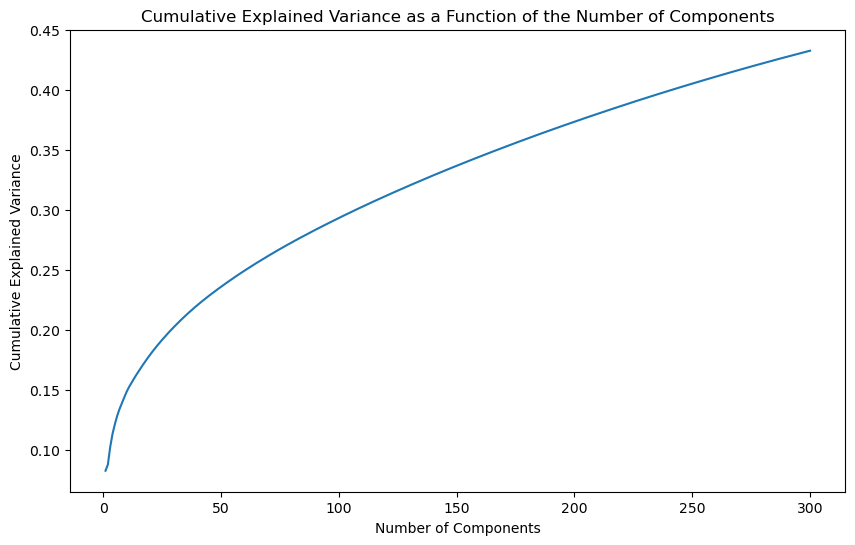

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Assume 'features' is your TF-IDF matrix
svd = TruncatedSVD(n_components=300)
svd.fit(features)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 301), np.cumsum(svd.explained_variance_ratio_))
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()


### Meta-Features
here we will add meta-features like the length of the email, which could also be predictive.

In [36]:
# Add email length as a feature
email_lengths = df['Clean_Body'].apply(len).values.reshape(-1, 1)

# Combine TF-IDF features with the email length
import numpy as np
features = np.hstack((features, email_lengths))

### Feature Visualization with t-SNE
t-SNE is a tool to visualize high-dimensional data by reducing it to two or three dimensions

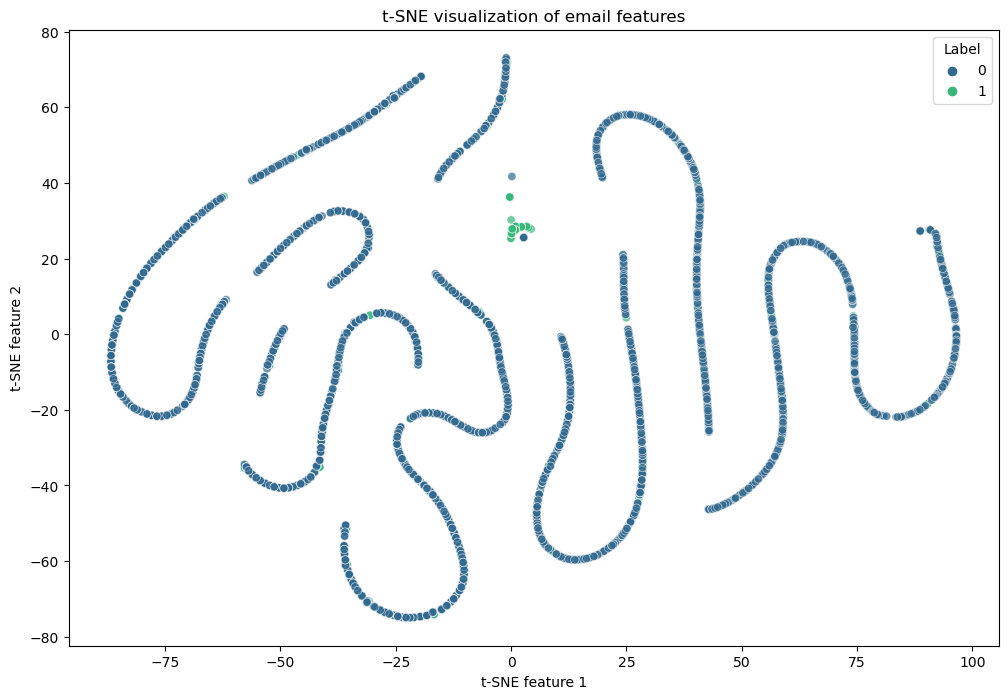

In [37]:
from sklearn.manifold import TSNE

# Use t-SNE to project the features into 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
features_reduced = tsne.fit_transform(features)

# Plot the result of t-SNE
plt.figure(figsize=(12, 8))
sns.scatterplot(x=features_reduced[:, 0], y=features_reduced[:, 1], hue=df['Label'], palette='viridis', alpha=0.7)
plt.title('t-SNE visualization of email features')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


### Feature Reduction with PCA
Principal Component Analysis (PCA) is another dimensionality reduction technique. It's faster than t-SNE and also useful for feature selection.

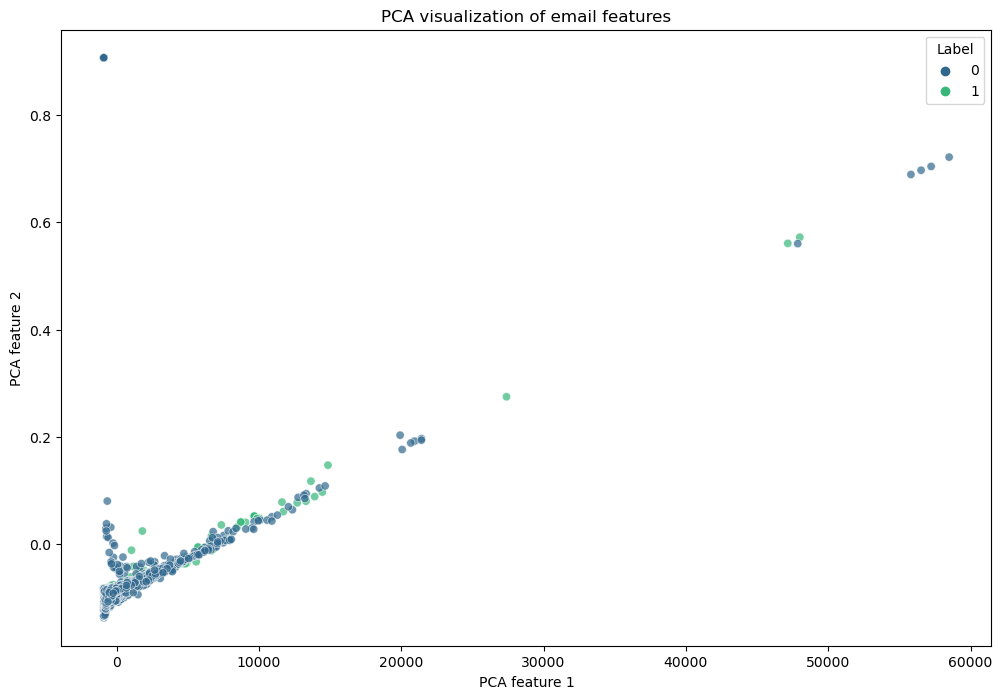

In [38]:
from sklearn.decomposition import PCA

# Use PCA to reduce the features to 2 dimensions
pca = PCA(n_components=2)
features_reduced_pca = pca.fit_transform(features)

# Plot the result of PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x=features_reduced_pca[:, 0], y=features_reduced_pca[:, 1], hue=df['Label'], palette='viridis', alpha=0.7)
plt.title('PCA visualization of email features')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.show()